# Fraudulent transactions detector

Following, a variety of models will be trained and evaluated to predict fraudulent incidents effectively based on [this dataset from Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download).
 
Each row in `fraud_data.csv` corresponds to a credit card transaction. Features include confidential variables `V1` through `V28` as well as the `Amount` which is the amount of the transaction. Due to confidentiality issues, the original features and more background information about the data can not be provided.
 
The target is stored in the `class` column, where a value of 1 corresponds to an instance of fraudulent and 0 corresponds to an instance of non-fraudulent transaction.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

## Exploring and preparing the data

First the data has to be imported from `fraud_data.csv`. To get a feeling about the data set the the proportion of fraudulent transactions can be calculated:

In [2]:
df       = pd.read_csv('fraud_data.csv')
fraud    = df[df['Class']==1]
notfraud = df[df['Class']==0]

print('Proportion of fraudulent transactions: {:.2f}%'
     .format(len(fraud)/len(notfraud)*100))
# df.head()

Proportion of fraudulent transactions: 1.67%


Plotting the distribution of both fraudulent and not-fraudulent transactions for each feature:

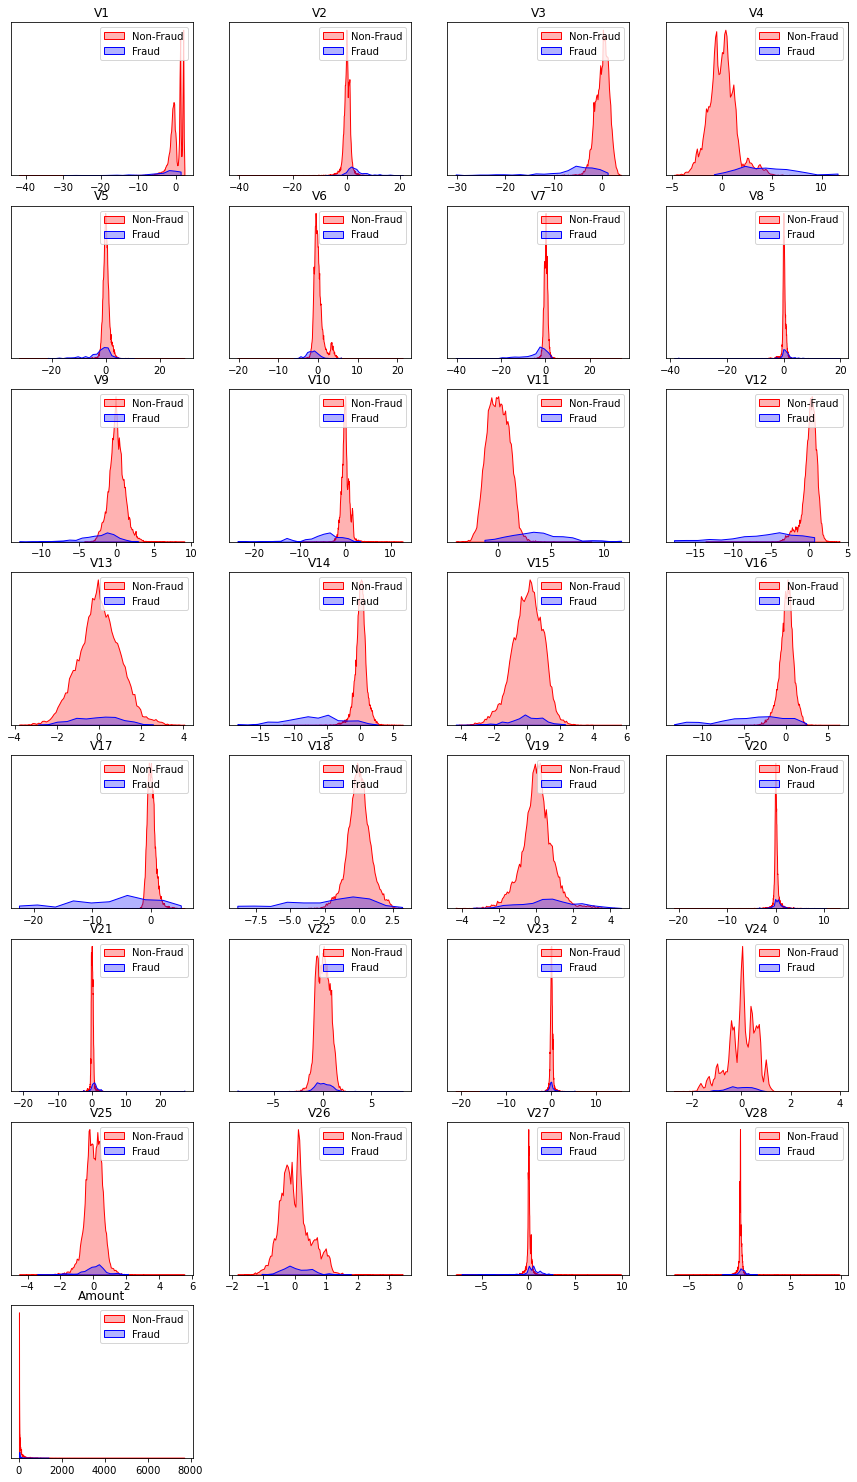

In [3]:
columns = df.iloc[:,0:29].columns
plt.figure(figsize=(15,50))
grids = gridspec.GridSpec(15, 4)

for grid, index in enumerate(df[columns]):
    ax = plt.subplot(grids[grid])
    sns.histplot(df[index][df.Class == 0], color="red",  label='Non-Fraud', alpha=0.3,  element="poly")
    sns.histplot(df[index][df.Class == 1], color="blue", label='Fraud',     alpha=0.3,  element="poly")
    ax.set_xlabel("\n")
    ax.set_ylabel("")
    ax.set_ylabel("")
    ax.set_yticks([])
    ax.set_title(str(index))
    plt.legend()

plt.show()

We see from the distribution diagrams, that some features (V1, V2) have lower impact than others (V3, V4) whether the transaction is fraudulent. We see also from the x-axes that the data is normalized (except of the Amount).

Since there is only one data set available, it must be split into two sets: **a training and a test set**.

In [4]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## ML models

Since we want the model to predict the most fraudulent transactions but not annoy with non-fraudulent as fraudulent transactions, this task will be **recall**-oriented.

### 1. Dummy classifier

Using `X_train`, `X_test`, `y_train`, and `y_test`, a **dummy** classifier that classifies transaction as the **most frequent** transaction of the training data (non-fraudulent), will be trained.

The accuracy, recall and precision score of the **dummy** model are shown.


In [5]:
dummy        = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
confusion    = confusion_matrix(y_test, y_pred_dummy)


print('Accuracy of the dummy classifier on test set: {:.2f}%'
     .format(dummy.score(X_test, y_test)*100))
print('Recall of the dummy classifier on test set: {:.2f}%'
     .format(recall_score(y_test, y_pred_dummy)*100))
print('\nConfusion matrix of the dummy classifier:\n', confusion)

Accuracy of the dummy classifier on test set: 98.53%
Recall of the dummy classifier on test set: 0.00%

Confusion matrix of the dummy classifier:
 [[5344    0]
 [  80    0]]


While the dummy classifier delivers a very good accuracy, its recall is 0%. This is because there is no **true positives** in the predection. In other words no fraudulent transaction has been classified as fraudulent.

### 2. Support Vector Classification
Now a **SVC** classifer will be trained using the default parameters.

The accuracy, recall, and precision of the **SVC** model are shown.

In [6]:
svc_clf    = SVC().fit(X_train, y_train)
y_pred_svc = svc_clf.predict(X_test)

acc_svc = svc_clf.score(X_test, y_test)
re_svc  = recall_score(y_test, y_pred_svc)
pr_svc  = precision_score(y_test, y_pred_svc)

print('Accuracy of the SVC classifier using the default parameters: {:.2f}%'
     .format(acc_svc*100))
print('Recall of the SVC classifier using the default parameters: {:.2f}%'
     .format(re_svc*100))
print('Precision of the SVC classifier using the default parameters: {:.2f}%'
     .format(pr_svc*100))

Accuracy of the SVC classifier using the default parameters: 99.00%
Recall of the SVC classifier using the default parameters: 35.00%
Precision of the SVC classifier using the default parameters: 93.33%


The **SVC** model achieves a good accuracy and percision. But the recall is still low.

### 3. Logistic Regression

A logisitic regression classifier with default parameters will now be trained.



In [7]:
lr         = LogisticRegression(max_iter=1000).fit(X_train, y_train)
y_pred_svc = lr.predict(X_test)

acc_lr = lr.score(X_test, y_test)
re_lr  = recall_score(y_test, y_pred_svc)
pr_lr  = precision_score(y_test, y_pred_svc)

print('Accuracy of the SVC classifier using the default parameters: {:.2f}%'
     .format(acc_lr*100))
print('Recall of the SVC classifier using the default parameters: {:.2f}%'
     .format(re_lr*100))
print('Precision of the SVC classifier using the default parameters: {:.2f}%'
     .format(pr_lr*100))

Accuracy of the SVC classifier using the default parameters: 99.67%
Recall of the SVC classifier using the default parameters: 80.00%
Precision of the SVC classifier using the default parameters: 96.97%


The linear model with the logistic function achieves a good recall (80%). By tuning the hyperparameters even a higher recall might be achievable. 

### 4. Tuning the parameter for the Logisitic Regression classifier

A grid search will be performed over the parameters listed below for a Logisitic Regression classifier, using **recall** for scoring and the default 3-fold cross validation. The tuning parameters are the `penalty` which define the regularization (**l1** for Lasso or **l2** for Ridge) and the regularization factor `C`.

`'penalty': ['l1', 'l2']`

`'C':[0.01, 0.1, 1, 10, 100]`


Text(0.5, 1.0, 'Logistic Regression classifer refined for recall')

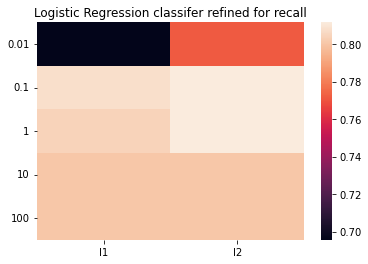

In [8]:
lr       = LogisticRegression(solver="liblinear")
values   = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]}
grid_rec = GridSearchCV(lr, param_grid = values, scoring = 'recall').fit(X_train, y_train)
GS       = grid_rec.cv_results_['mean_test_score'].reshape(5, 2)

plt.figure()
sns.heatmap(GS, xticklabels=['l1','l2'], yticklabels=[0.01, 0.1, 1, 10, 100])
plt.yticks(rotation=0)
plt.title('Logistic Regression classifer refined for recall')

<img src="heatmap.png">

Using the `penalty` **l2** (Ridge) leads to higher recall than **l1** (Lasso) in this example. A wheighting factor `C` between 0.74 and 0.8 delivers the best recall using the logistic function classifier with Ridge regularization.

This task is a modified assignment form a Machine Learning course by the **University of Michigan**.